<a href="https://colab.research.google.com/github/Suganthan-Mohanadasan/sitemap_sampling/blob/master/Sitemap_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sitemap Sampling
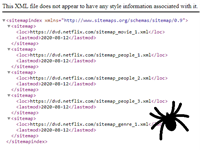

</div>

This notebook crawls standard sitemaps as well as sitemap indexes and extracts found URLs.  It creates a smaller set of randomly sampled URLs based on confidence interval and confidence level settings you supply.  This is useful when crawling a site so that you have an idea of the URLs you need to crawl to gain an accurate picture.

Sample URLs are saved to CSV and path part statitics are presented to ensure that your sample covers URLs at a similar ratio as the full set.



## Imports

In [ ]:
import pandas as pd
import requests
import gzip
from bs4 import BeautifulSoup
from urllib.parse import urlparse
from tqdm.auto import tqdm
from collections import Counter
import re
import random
import math

## All Functions

In [ ]:
## Sampling Function

#Original here: http://bc-forensics.com/?p=15
# SUPPORTED CONFIDENCE LEVELS: 50%, 68%, 90%, 95%, and 99%
confidence_level_constant = [50,.67], [68,.99], [90,1.64], [95,1.96], [99,2.57]
 
# CALCULATE THE SAMPLE SIZE
def calc_sample_size(population_size, confidence_level, confidence_interval):
    Z = 0.0
    p = 0.5
    e = confidence_interval/100.0
    N = population_size
    n_0 = 0.0
    n = 0.0

    # LOOP THROUGH SUPPORTED CONFIDENCE LEVELS AND FIND THE NUM STD
    # DEVIATIONS FOR THAT CONFIDENCE LEVEL
    for i in confidence_level_constant:
        if i[0] == confidence_level:
            Z = i[1]

    if Z == 0.0:
        return -1

    # CALC SAMPLE SIZE
    n_0 = ((Z**2) * p * (1-p)) / (e**2)

    # ADJUST SAMPLE SIZE FOR FINITE POPULATION
    n = n_0 / (1 + ((n_0 - 1) / float(N)) )

    return int(math.ceil(n)) # THE SAMPLE SIZE



# Recursively reads sitemaps handling compression
def read_sitemaps(s_url, results = [], limit=100, first=True):


  headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.105 Safari/537.36","Accept-Encoding": "gzip"}

  try:

      while len(results) < limit or limit == -1:

        response = requests.get(s_url, headers=headers)

        if response.headers['Content-Type'].lower() == 'application/x-gzip':
            xml = gzip.decompress(response.content)
        else:
            xml = response.content

        soup = BeautifulSoup(xml, "lxml")

        urls = [u.get_text() for u in soup.find_all("loc")]

        if first:
          print('Reading sitemap URLs for:', s_url)
          urls = tqdm(urls)

        for url in urls:
          if '.xml' in url:
            read_sitemaps(url, results=results, 
                               limit=limit,
                               first=False
                                )
          else:
            results.append(url)

        break

  except Exception as e:
      print('Read Sitemap Error: ',str(e))
      return None

  return results



# Main calculation function.
def calculate_samples(all_urls, confidence_level=95, confidence_interval=5):

  count_urls = len(all_urls)

  sample_size = calc_sample_size(count_urls, confidence_level, confidence_interval)
  rand_sample = [ i for i in random.sample(range(count_urls), sample_size) ]

  sample_urls = [ all_urls[i] for i in rand_sample]

  print("Sample URLs: {smp} | Total URLs: {tot} | Confidence Level: {cl} | Confidence Interval: {ci}".format(smp=len(sample_urls),
                                                                                                       tot=count_urls,
                                                                                                       cl=confidence_level,
                                                                                                       ci=confidence_interval))
  return sample_urls


# Saves samples to file, returns DataFrame.
def save_samples(sample_urls, output_filename='samples_output.csv', col_name='samples' ):
  df = pd.DataFrame({col_name:sample_urls})
  df.to_csv(output_filename, index=False)
  print('Saved samples to:', output_filename)
  return df


# Calculates comparison of path segment metrics.
def calculate_path_metrics(all_urls, sample_urls, top_n=100):

  n_all = len(all_urls)
  n_sample = len(sample_urls)

  if not n_all or not n_sample:
    print('Length of all_urls and all_samples must be greater than zero.')
    return None

  print('Converting all URLs to path frequencies.')
  all_url_paths = [s for i in tqdm(all_urls) if len(urlparse(i).path) for s in urlparse(i).path.split('/') if len(s)]

  print('Converting sample URLs to path frequencies.')
  sample_url_paths = [s for i in tqdm(sample_urls) if len(urlparse(i).path) for s in urlparse(i).path.split('/') if len(s)]

  all_count = Counter(all_url_paths)
  sample_count = Counter(sample_url_paths)

  df = pd.DataFrame([{'path_segment': i[0], 
                       'count_all': i[1], 
                       'percent_all': round(i[1]/n_all, 5), 
                       'count_sample': sample_count[i[0]],
                       'percent_sample': round(sample_count[i[0]]/n_sample, 5)} 
                      for i in all_count.most_common(top_n)])

  return df



## Parameters

In [ ]:
#@title Available Parameters: { run: "auto", display-mode: "form" }

#@markdown Sitemap Information:
sitemap_url = "https://dvd.netflix.com/sitemap_index.xml" #@param {type:"string"}
output_filename = "netflix_samples.csv" #@param {type:"string"}
url_limit =  -1#@param {type:"integer"}

#@markdown -----

#@markdown Statistical Information:
confidence_level = 99 #@param ["50", "68", "90", "95", "99"] {type:"raw"}
confidence_interval = 3 #@param {type:"slider", min:1, max:10, step:1}


## Execute


In [ ]:
# Grab sitemap URLs, recursively
all_urls = read_sitemaps(sitemap_url, limit=url_limit)
print()

# Extract samples based on parameters
sample_urls = calculate_samples(all_urls, 
                                confidence_level=confidence_level, 
                                confidence_interval=confidence_interval)
print()

# Save samples to CSV
df_samples = save_samples(sample_urls, output_filename)
print()

# Print coverage statistics
df_stats = calculate_path_metrics(all_urls, sample_urls, top_n=50)
print()

print('Comparison Stats')
df_stats.head(25)


Reading sitemap URLs for: https://dvd.netflix.com/sitemap_index.xml




Sample URLs: 1817 | Total URLs: 180108 | Confidence Level: 99 | Confidence Interval: 3

Saved samples to: netflix_samples.csv

Converting all URLs to path frequencies.



Converting sample URLs to path frequencies.




Comparison Stats


,path_segment,count_all,percent_all,count_sample,percent_sample
0,RoleDisplay,139540,0.77476,1414,0.77821
1,Movie,40044,0.22233,398,0.21904
2,Genre,524,0.00291,5,0.00275
3,The-Three-Musketeers,8,0.00004,0,0.00000
4,King-Lear,8,0.00004,0,0.00000
5,Home,7,0.00004,0,0.00000
6,Jane-Eyre,7,0.00004,0,0.00000
7,Cinderella,7,0.00004,0,0.00000
8,Rain,6,0.00003,0,0.00000
9,Robin-Hood,6,0.00003,0,0.00000
